In [1]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense


In [2]:
datapath = "../keypoints/"

In [3]:
kp_files = glob.glob(datapath + '*.txt')

In [4]:
# Get labels from file names
labels = [int(x.split('_')[0].split("/")[-1]) for x in kp_files]

In [5]:
# read in text files
len(labels)

19

In [54]:
data.head()

,time,kpoints,count,fps
0,1.605553e+09,"[(0, 0.529125452041626, 0.3717993199825287), (...",1,53.949502
1,1.605553e+09,"[(0, 0.5283065438270569, 0.37145838141441345),...",2,50.406855
2,1.605553e+09,"[(0, None, None), (1, None, None), (2, None, N...",3,51.169393
3,1.605553e+09,"[(0, 0.5283210277557373, 0.3713357150554657), ...",4,44.569522
4,1.605553e+09,"[(0, 0.5286968946456909, 0.37130624055862427),...",5,51.506828


In [142]:
channels = np.empty((450, 2))

for kp_i in range(len(kp_ind)):

    times = [t-data.time[0] for t in data.time]

    tcol = []
    ycol = []

    for t_i in range(len(times)):
        tp = times[t_i]
        y = data.kpoints[t_i][kp_i][2]

        tcol.append(tp)
        ycol.append(y)

    tcol = np.array(tcol).reshape(450, 1)
    ycol = np.array(ycol).reshape(450, 1)

    sel_kp = np.hstack((tcol, ycol))
    
    

    channels = np.dstack((channels, sel_kp))

channels = channels[:, :, 1:]

In [143]:
channels.shape

(450, 2, 9)

In [132]:
c2 = channels.reshape((450, 2, 9))

In [133]:
channels[1, 0:5, :]

array([[0.0, 0.3994360864162445],
       [0.05242013931274414, 0.3994216024875641],
       [0.1107945442199707, None],
       [0.1670398712158203, 0.3994859755039215],
       [0.23941922187805176, 0.3992924988269806]], dtype=object)

In [136]:
# for ch in channels:
# ch = channels[0]

arr = channels[0]
arr.shape

(450, 2)

In [145]:
#TESTING
kp_ind = [0, 1, 2, 3, 4, 5, 6, 7, 17]

features = []

for file in kp_files:
    data = pd.read_csv(file, sep="\t", header=None)
    data.columns = ["time", "kpoints", "count", "fps"]
    data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))
    times = [t-data.time[0] for t in data.time]
    
    sel_kp = []
    
    channels = np.empty((len(times), 2))

    for kp_i in range(len(kp_ind)):

        times = [t-data.time[0] for t in data.time]

        tcol = []
        ycol = []

        for t_i in range(len(times)):
            tp = times[t_i]
            y = data.kpoints[t_i][kp_i][2]

            tcol.append(tp)
            ycol.append(y)

        tcol = np.array(tcol).reshape(450, 1)
        ycol = np.array(ycol).reshape(450, 1)

        sel_kp = np.hstack((tcol, ycol))



        channels = np.dstack((channels, sel_kp))

    channels = channels[:, :, 1:]

    features.append(channels)

In [146]:
len(features)

19

In [147]:
features[0].shape

(450, 2, 9)

In [158]:
# Check to make sure channels are correct
# plt.scatter(features[0][:, 0, 0], features[0][:, 1, 0])

In [272]:
# # # SAVE DATA
# with open('features.txt', 'w') as filehandle:
#     for listitem in features:
#         filehandle.write('%s\n' % listitem)

# with open('labels.txt', 'w') as filehandle:
#     for listitem in labels:
#         filehandle.write('%s\n' % listitem)

In [159]:
X = np.array(features)
print(X.shape)

(19, 450, 2, 9)


In [105]:
Y = np.array(labels)
print(Y.shape)

(19,)


In [160]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [161]:
X_train.shape

(16, 450, 2, 9)

In [258]:
model = tf.keras.Sequential([
    Convolution2D(filters=32, kernel_size = (5,2), strides=(5,1), 
                  padding="same", 
                  input_shape=(450,2, 9), data_format='channels_last', 
                  activation="relu"),
#     MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(64, kernel_initializer="normal", activation='relu'),
    Dense(1, kernel_initializer="normal", activation='linear')
])



In [264]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.5), metrics=["mse", "mae"])

In [265]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 90, 2, 32)         2912      
_________________________________________________________________
flatten_16 (Flatten)         (None, 5760)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                368704    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 371,681
Trainable params: 371,681
Non-trainable params: 0
_________________________________________________________________


In [266]:
history = model.fit(X_train, Y_train, epochs=100)

Train on 16 samples
Epoch 1/100
16/16 [==============================] - 0s 25ms/sample - loss: 300.3015 - mean_squared_error: 300.3015 - mean_absolute_error: 14.3196
Epoch 2/100
16/16 [==============================] - 0s 2ms/sample - loss: 286.2314 - mean_squared_error: 286.2314 - mean_absolute_error: 13.8196
Epoch 3/100
16/16 [==============================] - 0s 1ms/sample - loss: 272.6761 - mean_squared_error: 272.6761 - mean_absolute_error: 13.3201
Epoch 4/100
16/16 [==============================] - 0s 2ms/sample - loss: 259.6437 - mean_squared_error: 259.6437 - mean_absolute_error: 12.8216
Epoch 5/100
16/16 [==============================] - 0s 3ms/sample - loss: 247.1414 - mean_squared_error: 247.1414 - mean_absolute_error: 12.3244
Epoch 6/100
16/16 [==============================] - 0s 3ms/sample - loss: 235.1753 - mean_squared_error: 235.1753 - mean_absolute_error: 11.8290
Epoch 7/100
16/16 [==============================] - 0s 2ms/sample - loss: 223.7505 - mean_squared_erro

Epoch 58/100
16/16 [==============================] - 0s 2ms/sample - loss: 95.9279 - mean_squared_error: 95.9279 - mean_absolute_error: 8.6617
Epoch 59/100
16/16 [==============================] - 0s 3ms/sample - loss: 95.8677 - mean_squared_error: 95.8677 - mean_absolute_error: 8.6430
Epoch 60/100
16/16 [==============================] - 0s 2ms/sample - loss: 95.8056 - mean_squared_error: 95.8056 - mean_absolute_error: 8.6227
Epoch 61/100
16/16 [==============================] - 0s 2ms/sample - loss: 95.7433 - mean_squared_error: 95.7433 - mean_absolute_error: 8.6012
Epoch 62/100
16/16 [==============================] - 0s 3ms/sample - loss: 95.6821 - mean_squared_error: 95.6821 - mean_absolute_error: 8.5787
Epoch 63/100
16/16 [==============================] - 0s 2ms/sample - loss: 95.6232 - mean_squared_error: 95.6232 - mean_absolute_error: 8.5555
Epoch 64/100
16/16 [==============================] - 0s 1ms/sample - loss: 95.5675 - mean_squared_error: 95.5675 - mean_absolute_error:

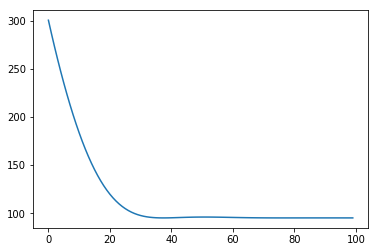

In [267]:
plt.plot(history.history['mean_squared_error'])

In [268]:
model.evaluate(X_test, Y_test)

3/3 [==============================] - 0s 77ms/sample - loss: 43.2954 - mean_squared_error: 43.2954 - mean_absolute_error: 6.0888


[43.2954216003418, 43.29542, 6.088776]

In [269]:
model.predict(X_test)

array([[23.42211],
       [23.42211],
       [23.42211]], dtype=float32)

In [270]:
train_pred = model.predict(X_train)

In [271]:
train_pred

array([[23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211],
       [23.42211]], dtype=float32)

In [210]:
Y_train

array([14, 18, 20, 18, 40, 18, 40, 14, 20, 20, 20, 40, 14, 20, 40, 20])

## Example plots

In [21]:
r_ear = []

for i in range(len(data.kpoints)):
    r_ear.append(data.kpoints[i][4][2])

Text(0.5,1,'R ear')

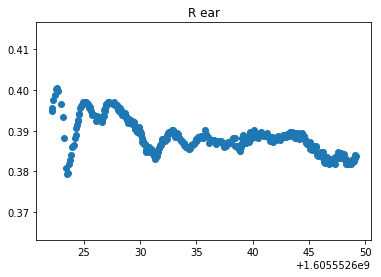

In [24]:
plt.scatter(data.time.values, r_ear)
plt.title("R ear")

Text(0.5,1,'R shoulder')

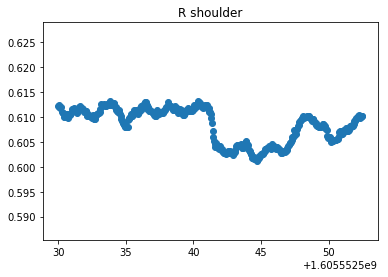

In [58]:
data = pd.read_csv(kp_files[4], sep="\t", header=None)
data.columns = ["time", "kpoints", "count", "fps"]
data.kpoints = data.kpoints.apply(lambda x: ast.literal_eval(x.strip("()")))

r_shoulder = []

for i in range(len(data.kpoints)):
    r_shoulder.append(data.kpoints[i][3][2])
    
plt.scatter(data.time.values, r_shoulder)
plt.title("R shoulder")